# Reproducibility of AI Trojan Detector Results 

#### Links
gitlab for SURF Project: https://gitlab.nist.gov/gitlab/dcj/2022-surf-trojai/

trojai example github: https://github.com/usnistgov/trojai-example/ 


### Setting up Slurm

If you haven't used slurm before, follow this tutorial to get you started

slurm tutorial: https://gitlab.nist.gov/gitlab/wtk/isg-wiki/-/wikis/Slurm-Nodes 


## Updating infoTrojAI.csv and tokenizerinfo.csv

If it's been a while since the August 2022, you will want to update these files. If you follow the gitlab link (https://gitlab.nist.gov/gitlab/dcj/2022-surf-trojai/) and go to testing/utilityCSVs, you should find two bash (.sh) files corresponding to infoTrojAI.csv and tokenizerinfo.csv. Transfer these to any NIST HPC node and run them. Place their outputs in the utilityCSVs folder

## Finding deterministic containers

#### Determinism 
- To find deterministic containers I first ran every container 3 times and collected the results in a csv file.

- I then turned this csv file into a pandas dataframe and dropped every container that had a standard deviation greater than epsilon (floating point error boung - usually around 2e-16).

- The resulting dataframe represents the deterministic containers.

#### Generating the tests for determinism

The below python snippet will generate a file called "TEST.sh" which you can run on any NIST Node with Slurm support. These are the tests I ran to find deterministic containers.

Example:

bash TEST.sh

In [1]:
import os
import sys

os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Full path to testing directory on your machine

FULLPATH = r'C:\Users\jal20\2022-surf-trojai\testing'


sys.path.insert(0, FULLPATH)

In [2]:
from scriptmaker import auto

In [3]:
HOMEDIR = r"C:\Users\jal20\2022-surf-trojai\documentation"
NODE = r"ENTER THE NAME OF A NIST HPC NODE YOU HAVE ACCESS TO"

In [4]:
#Generate Round 9 Determinism tests in TEST.sh file
auto(9,node=NODE ,homedir = HOMEDIR, iterations=3,cpus=10,model=0,driver="default", teams ="ALL" ,custom=False)

#Append Round 9 Determinism tests to TEST.sh file
auto(4,node=NODE ,homedir = HOMEDIR, iterations=3,cpus=10,model=0,driver="default", teams ="ALL" ,custom=False)

In [5]:
from scriptmaker import compiler

In [6]:

#Generate a compiler file that  
compiler(9, experiment = "Determinism9", node=NODE ,homedir = HOMEDIR, iterations=3,cpus=10,model=0,driver="default", teams ="ALL" ,custom=False)

#Round 4 Determinism
compiler(4, experiment = "Determinism4", node=NODE ,homedir = HOMEDIR, iterations=3,cpus=10,model=0,driver="default", teams ="ALL" ,custom=False)


C:\Users\jal20\2022-surf-trojai\testing
C:\Users\jal20\2022-surf-trojai\testing


After you've launched your tests by entering the command "bash TEST.sh" and have compiled your results with "bash COMPILER.sh", transfer over the results from "compiledResults.csv", which should be found in the folder where you launched the tests from.

Take Determinism9.csv and Determinism4.csv, put them into the data folder, and replace my default results. 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [8]:
# rough floating point error to account for fractional outputs whose standard deviation might be imprecise 
epsilon = 1e-10

deterministicContainers = {}
runningContainers = {}

def findDeterministic(filepath):
    df = pd.read_csv(filepath,index_col = False)
    print(df)
    df.dropna(how="any", axis = 1)
    runningContainers[df['round'].unique()[0]] = df['team'].unique()
    df['STD'] = df[['1','2','3']].std(axis=1)
    df = df[df['STD'] < epsilon]
    # feel free to use the pd.DataFrame.to_csv() method to convert dataframes to csv files
    return df 

#Generate a dict with deterministic containers from round 4 and 9
def deterministicList(df) :
    templ = []
    for team in df['team'].unique():
        templ.append(team)
    deterministicContainers[df['round'].unique()[0]] = templ

deterministicList(findDeterministic(r"data/Determinism4.csv"))
deterministicList(findDeterministic(r"data/Determinism9.csv"))

print(deterministicContainers)
print(runningContainers)

    


     round     node  cpus   driver  team                    model         1  \
0   round4  charlie    10  default  id-0                 ARM-UMBC  0.550720   
1   round4  charlie    10  default  id-0             Cassandra-XF       NaN   
2   round4  charlie    10  default  id-0                   DRAFFT  0.214908   
3   round4  charlie    10  default  id-0                   Hector       NaN   
4   round4  charlie    10  default  id-0                 IceTorch       NaN   
5   round4  charlie    10  default  id-0                     ICSI       NaN   
6   round4  charlie    10  default  id-0                 ICSI-UMD  0.950000   
7   round4  charlie    10  default  id-0            NIST-baseline       NaN   
8   round4  charlie    10  default  id-0                     NSEC       NaN   
9   round4  charlie    10  default  id-0                Perspecta       NaN   
10  round4  charlie    10  default  id-0            Perspecta-IUB  0.566667   
11  round4  charlie    10  default  id-0  Perspecta-

## Core Count tests
 
##### Deterministic Containers
Running a deterministic container once with a single core and then a second time with 10 cores should suffice to see if cpu core count has a measurable impact on results.

##### Non-Deterministic Containers
We didn't end up presenting any findings about this class of algorithm but if I were to test them, here's what I would do:

For non-deterministic containers I recommend ~10 runs on core counts of 3 different magnitudes (for my tests I chose 1, 5, 10, 21, 30, and 40) Then for each pair I'd recommend using a statistical test such as a Kolmogorov-Smirnov Test to verify that all results originiate from the same distribution. 

In [9]:
#Round 9 CPU Core Tests
auto(9,node=NODE ,homedir = HOMEDIR, iterations=1,cpus=10,model=0,driver="default", teams =deterministicContainers['round9'] ,custom=False)
auto(9,node=NODE ,homedir = HOMEDIR, iterations=1,cpus=1,model=0,driver="default", teams =deterministicContainers['round9'] ,custom=False)

#Round 4 CPU Core Tests 
#auto(4,node=NODE ,homedir = HOMEDIR, iterations=1,cpus=10,model=0,driver="default", teams =deterministicContainers['round4'] ,custom=False)
#auto(4,node=NODE ,homedir = HOMEDIR, iterations=1,cpus=1,model=0,driver="default", teams =deterministicContainers['round4'] ,custom=False)


In [10]:
#Round 9 CPU Core Tests
compiler(9,node=NODE , experiment = "CoresDeterminism9",homedir = HOMEDIR, iterations=1,cpus=10,model=0,driver="default", teams =deterministicContainers['round9'] ,custom=False)
compiler(9,node=NODE, experiment = "CoresDeterminism9" ,homedir = HOMEDIR, iterations=1,cpus=1,model=0,driver="default", teams =deterministicContainers['round9'] ,custom=False)

#Round 4 CPU Core Tests 
#compiler(4,node=NODE, experiment = "CoresDeterminism4" ,homedir = HOMEDIR, iterations=1,cpus=10,model=0,driver="default", teams =deterministicContainers['round4'] ,custom=False)
#compiler(4,node=NODE, experiment = "CoresDeterminism4" ,homedir = HOMEDIR, iterations=1,cpus=1,model=0,driver="default", teams =deterministicContainers['round4'] ,custom=False)


In [11]:
# input is csv with columns: "round,node,cpus,driver,team,model,1,2,3,4,5,6,7,8 ..."

#r4Cores = pd.read_csv(r"data/CoresDeterminism4.csv")
#r9Cores = pd.read_csv(r"data/CoresDeterminism9.csv")


def deterministicCPU(df):
    teams = df['teams'].unique()
    cores = df['cpus'].unique()
    
    outDf = pd.DataFrame(columns = ['cpus', 'team','AVG', 'STD'], index = None)

    for team in teams: 
        for core in cores:
            outDf.loc[len(outDf.index)] = [core, team, 
            np.average(df[(df['cpus'] == core) & (df['team'] == team)].values[0][6:]), 
            np.std(df[(df['cpus'] == core) & (df['team'] == team)].values[0][6:])]
    
    return outDf

# The output DataFrame should look like the table below except with AVG and STD columns instead of 'probability'
# Due to time constraints I was not able to get a clean set of data that would work with the above program. 


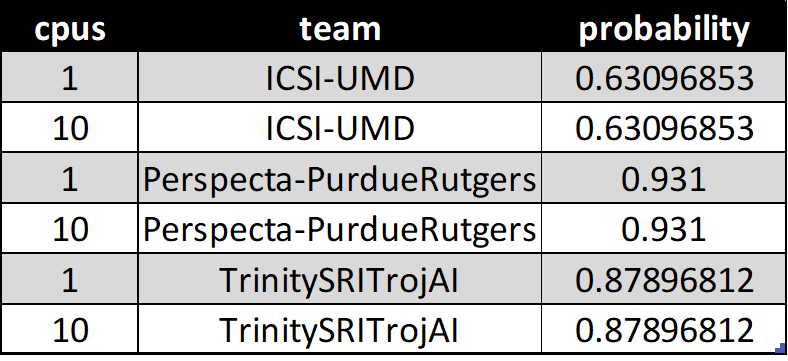

## Model Tweaks 

Using my model tweaking code (SEE BELOW), I tweaked a model 10 different times at both the 16 and 32 bit level. The values obatained from testing the tweaked models was graphed alongside all other data obtained on machines I could use - these machines were of course running the untweaked version of the model. 



In [12]:
#method that tweaks a given ratio of pytorch AI model parameters by the smallest amount in a random direction 
def tweak(modelfilepath, outputfile,bits):
    
    model = torch.load(modelfilepath)
    model.requires_grad_(False)
    
    for tensor in model.parameters():
        PM32 = torch.from_numpy(np.random.choice(a=[np.inf, -np.inf], size =tensor.size(), p=[0.5,0.5]))
        PM16 = np.random.choice(a=[np.inf, -np.inf], size =tensor.size(), p=[0.5,0.5])

        if bits == 32:
            temp = np.nextafter(tensor,PM32,dtype=np.float32)
            temp = np.nextafter(temp,PM32,dtype=np.float32)

        elif bits == 16:
            temp = tensor.detach().numpy().astype('float16')
            temp = np.nextafter(temp,PM16,dtype=np.float16)
            temp = temp.astype('float32')
            temp = torch.from_numpy(temp)
        
        # change p value to change share of parameters that get "tweaked" default is 50%
        mask = torch.from_numpy(np.random.choice(a=[True,False], size = tensor.size(), p=[0.5, 0.5]))
        tensor[mask] = temp[mask]

    model.requires_grad_(True)
    torch.save(model,f=outputfile)
        


After successfully tweaking the models, I transferred them to the NIST HPC Database and ran 10 of them from round 9 - chose an array of different models. I only included 16 bit tweaks here because 32 bit tweaks were too small to make a difference

In [13]:
#driver = "default"

#auto(9, node=NODE ,homedir = HOMEDIR, iterations=10, cpus=10, model=0, driver=driver, teams = deterministicContainers['round9'], custom=True, bits = 16)
#auto(9, node=NODE ,homedir = HOMEDIR, iterations=10, cpus=10, model=3, driver=driver, teams = deterministicContainers['round9'], custom=True, bits = 16)
#auto(9, node=NODE ,homedir = HOMEDIR, iterations=10, cpus=10, model=8, driver=driver, teams = deterministicContainers['round9'], custom=True, bits = 32)
#auto(9, node=NODE ,homedir = HOMEDIR, iterations=10, cpus=10, model=12, driver=driver, teams = deterministicContainers['round9'], custom=True, bits = 32)

#compiler(9, experiment = "tweakTests16bit", node=NODE ,homedir = HOMEDIR, iterations=10, cpus=10, model=0, driver=driver, teams = deterministicContainers['round9'], custom=True)
#compiler(9, experiment = "tweakTests16bit", node=NODE ,homedir = HOMEDIR, iterations=10, cpus=10, model=3, driver=driver, teams = deterministicContainers['round9'], custom=True)
#compiler(9, experiment = "tweakTests16bit", node=NODE ,homedir = HOMEDIR, iterations=10, cpus=10, model=8, driver=driver, teams = deterministicContainers['round9'], custom=True)
#compiler(9, experiment = "tweakTests16bit", node=NODE ,homedir = HOMEDIR, iterations=10, cpus=10, model=12, driver=driver, teams = deterministicContainers['round9'], custom=True)


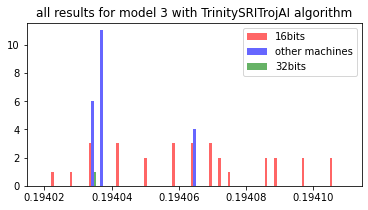

In [14]:
# script used to generate histogram plots for Model tweaks
#df = pd.read_csv(r"data/tweakTests16bit")

#print your model options 
#print(df['model'].unique())

#filter by singular model using below code 
#df16input = df[df['model'] == "INSERT MODEL OPTION HERE"]

df16_TrinityExample = pd.read_csv( HOMEDIR + r"\data\16bitTrinitySRI.csv")
df32_TrinityExample = pd.read_csv(HOMEDIR + r"\data\32bitTrinitySRI.csv")
dfOther_TrinityExample = pd.read_csv(HOMEDIR + r"\data\AllMachines_TrinitySRI.csv")


# filter by singular model 
def tweakplot(df16, dfother,df32):
    plt.figure(figsize=(6,3))
    l = []
    bins = set()
    dftype = type(pd.DataFrame())
    
    if type(df16) == dftype:
        # [:6] slicing is based off csv file having shape => round,node,cpus,driver,team,model,1,2,3 ...
        data16 = df16.drop(columns = df16.columns[:6])
        data16 = data16.values.tolist()
        # line below flattens a 2d array into 1 dimension
        data16 = [x for xs in data16 for x in xs] 
        
        for data in data16:
            bins.add(data)

        l.append(data16)

    if type(df32) == dftype: 
        data32 =  df32.drop(columns = df32.columns[:6])
        data32 = data32.values.tolist()
        data32 = [x for xs in data32 for x in xs] 

        for data in data32:
            bins.add(data)


        l.append(data32)

    if type(dfother) == dftype:
        othermachines = dfother['1'].tolist()

        for data in othermachines:
            bins.add(data)

        l.append(othermachines)

    # scale range as needed 

    avg = np.average(l[0])
    std = np.std(l[0])

    plt.hist(l, alpha=0.6, color=["r", "b", 'g'][:len(l)],range = (avg - 2 * std, avg + 2 * std), bins = len(bins))
    # change title as needed 
    plt.title("all results for model 3 with TrinitySRITrojAI algorithm")
    plt.legend(["16bits" , "other machines", "32bits"])
    plt.show()

# Example plot as used in presentation 
tweakplot(df16_TrinityExample, df32_TrinityExample, dfOther_TrinityExample)

## GPU Driver Tests

We ran all containers 3 times on different GPU drivers and then constructed a dataframe where the columns represented different detector algorithms and the rows were different GPU drivers. The raw code we used to do this is in the gitlab. Due to time constraints, however, I wasn't able to clean it up. Therefore I will instead provide an example csv that I made using the code.

To add the dates, you'll have to access the "version" part of the submissions tree. 

Some of the different drivers I tested were: 
515.43.04, 510.73.08, 495.29.05, 470.129.06

on a RTX 3090 GPU

In [15]:
drivers = ['515.43.04', '510.73.08', '495.29.05', '470.129.06']
# on the RTX 3090 GPU 

# manually increment the index 
driver = drivers[0]
# manually change GPU driver on desired node

# Round 9 GPU Driver tests
auto(9, node=NODE ,homedir = HOMEDIR, iterations=3, cpus=10, model=0, driver=driver, teams = deterministicContainers['round9'], custom=False)
compiler(9, node=NODE, experiment = "driverTests9", homedir = HOMEDIR, iterations=3, cpus=10, model=0, driver=driver, teams = deterministicContainers['round9'], custom=False)

# Round 4 GPU driver tests 
#auto(4, node=NODE ,homedir = HOMEDIR, iterations=3, cpus=10, model=0, driver=driver, teams = deterministicContainers['round4'], custom=False)
#compiler(4, node=NODE, experiment = "driverTests4", homedir = HOMEDIR, iterations=3, cpus=10, model=0, driver=driver, teams = deterministicContainers['round4'], custom=False)


In [16]:
#inp4 = pd.read_csv(r"data/driverTests4")
#inp9 = pd.read_csv(r"data/driverTests4")

ex9 = pd.read_csv(r"C:\Users\jal20\2022-surf-trojai\documentation\data\driversTests.csv")

def driveranalysis(df):
    
    outDf = pd.DataFrame(columns = df['team'].unique(), index = df['driver'].unique())
    
    for team in df['team'].unique():
        for driver in df['driver'].unique():
            if (len(df[(df['team'] == team) & (df['driver'] == driver)].values) > 0):
                outDf.at[driver,team] = np.std(df[(df['team'] == team) & (df['driver'] == driver)].values[0][6:])
    
    return outDf


df = driveranalysis(ex9)
print(df)

           ARM-UCSD ICSI-2 ICSI-UMD Perspecta-IUB Perspecta-PurdueRutgers  \
460.106.00      NaN    NaN      0.0       0.18498                     NaN   
470.129.06      0.0    NaN      0.0      0.302763                     0.0   
495.29.05       0.0    NaN      0.0      0.304974                     0.0   
510.73.08       0.0    NaN      0.0      0.286386                     0.0   
515.43.04       0.0    NaN      0.0      0.301045                     0.0   

             PL-GIFT TrinitySRITrojAI TrinitySRITrojAI-BostonU  \
460.106.00       0.0              0.0                 0.043339   
470.129.06  0.007309              0.0                 0.056161   
495.29.05   0.007309              0.0                 0.104211   
510.73.08        0.0              0.0    80302952425786.296875   
515.43.04   0.007309              0.0                 0.038133   

           TrinitySRITrojAI-SBU trojai-example  
460.106.00             0.004258            NaN  
470.129.06             0.007015           

The above Code should return a table with the standard deviations of the algorithms tested indexed by driver 

Note that the cell entries contain the average probabilities and not the standard deviations - the table produced by the above code has the standard deviations in the cells instead of the averages. 

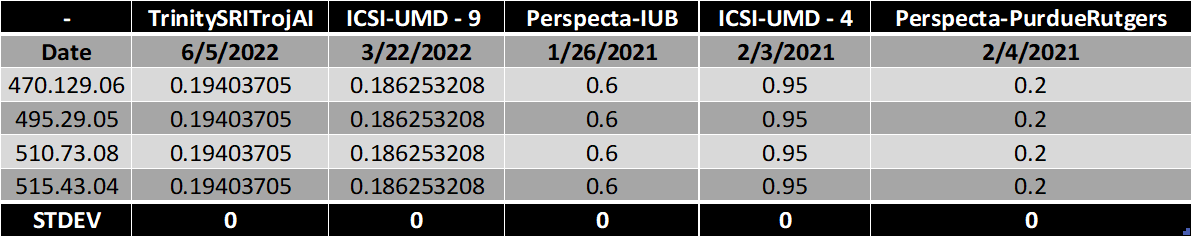